STEP 1: DATA PREPROCESSING (SPIKE ENCODING)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

T = 20
num_samples = 5

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

sample_indices = [i for i in range(len(mnist_dataset)) if mnist_dataset[i][1] in range(10)]
random.shuffle(sample_indices)

images = []
labels = []

for idx in sample_indices:
    img, label = mnist_dataset[idx]
    images.append(img.squeeze(0))
    labels.append(label)
    if len(images) == num_samples:
        break

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]


In [30]:
def Poisson_encode(image, time_steps):
    image = image.unsqueeze(0).repeat(time_steps, 1, 1)
    rand_vals = torch.rand_like(image)
    spikes = (rand_vals < image).float()
    return spikes

In [7]:
def visualize_spike_train_2d(spike_train, label, sample_idx):
    T = spike_train.shape[0]
    fig, axs = plt.subplots(4, 5, figsize=(12, 10))
    axs = axs.flatten()

    for t in range(T):
        axs[t].imshow(spike_train[t], cmap='gray')
        axs[t].set_title(f"Time {t}")
        axs[t].axis('off')

    plt.suptitle(f"Digit: {label} | Sample #{sample_idx} (2D Spike View)", fontsize=16)
    plt.tight_layout()
    plt.show()

In [4]:
def visualize_spike_train(spike_train, label, sample_idx):
    T, H, W = spike_train.shape
    spike_points = []

    for t in range(T):
        y, x = torch.where(spike_train[t] > 0)
        for i in range(len(y)):
            spike_points.append((x[i].item(), y[i].item(), t))

    spike_points = np.array(spike_points)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(spike_points[:, 0], spike_points[:, 1], spike_points[:, 2], s=3, c=spike_points[:, 2], cmap='viridis')
    ax.set_title(f"Digit: {label} | Sample #{sample_idx}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Time Step")
    plt.tight_layout()
    plt.show()

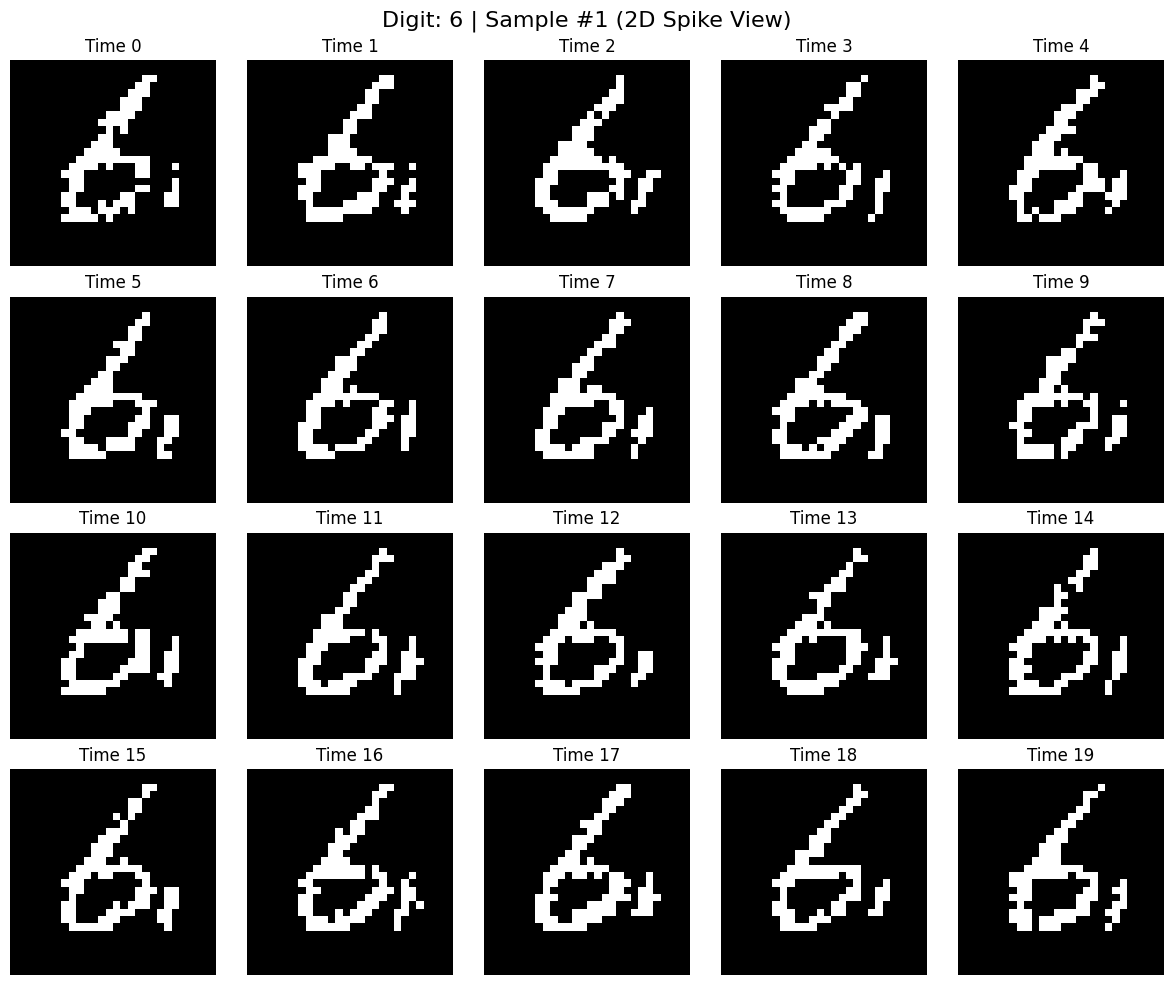

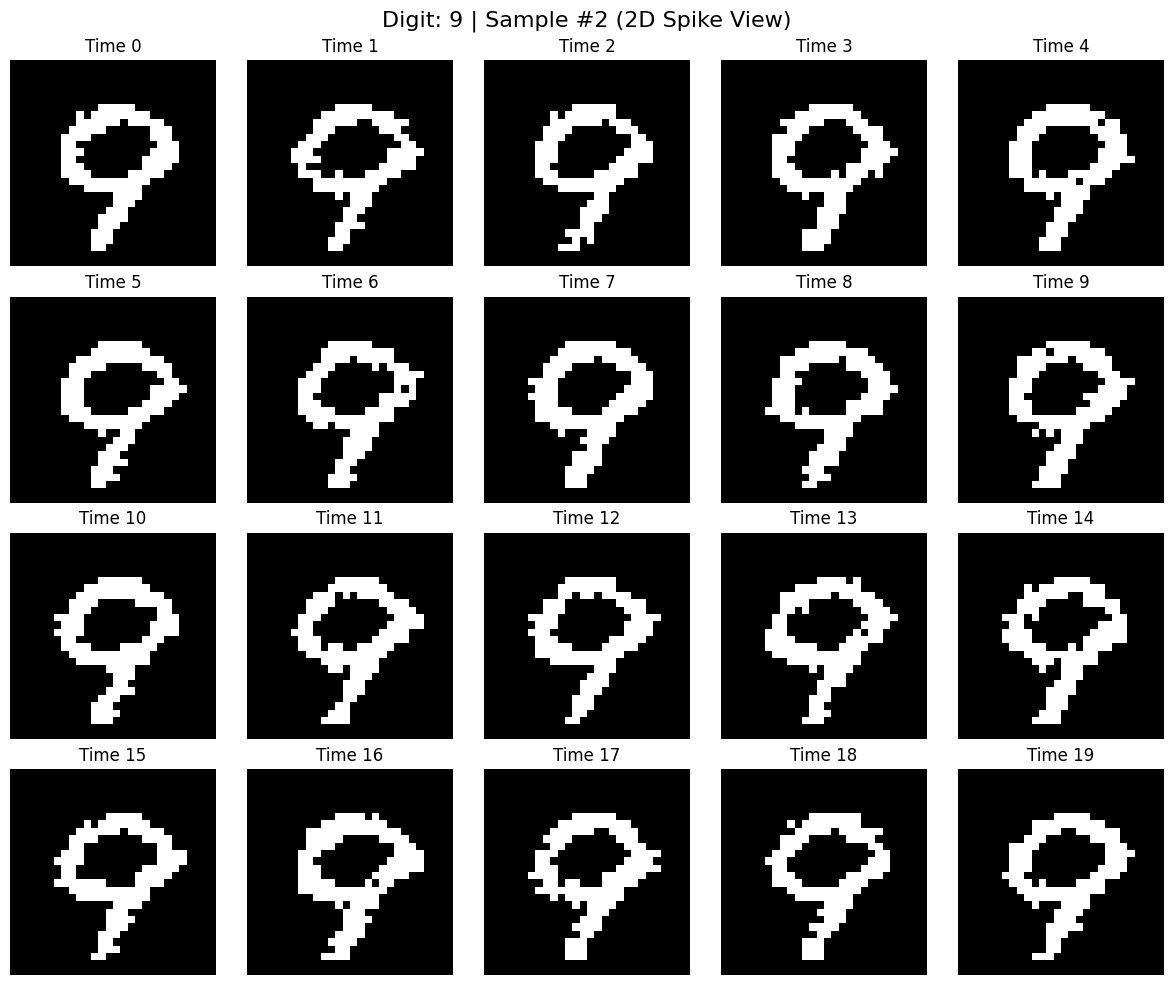

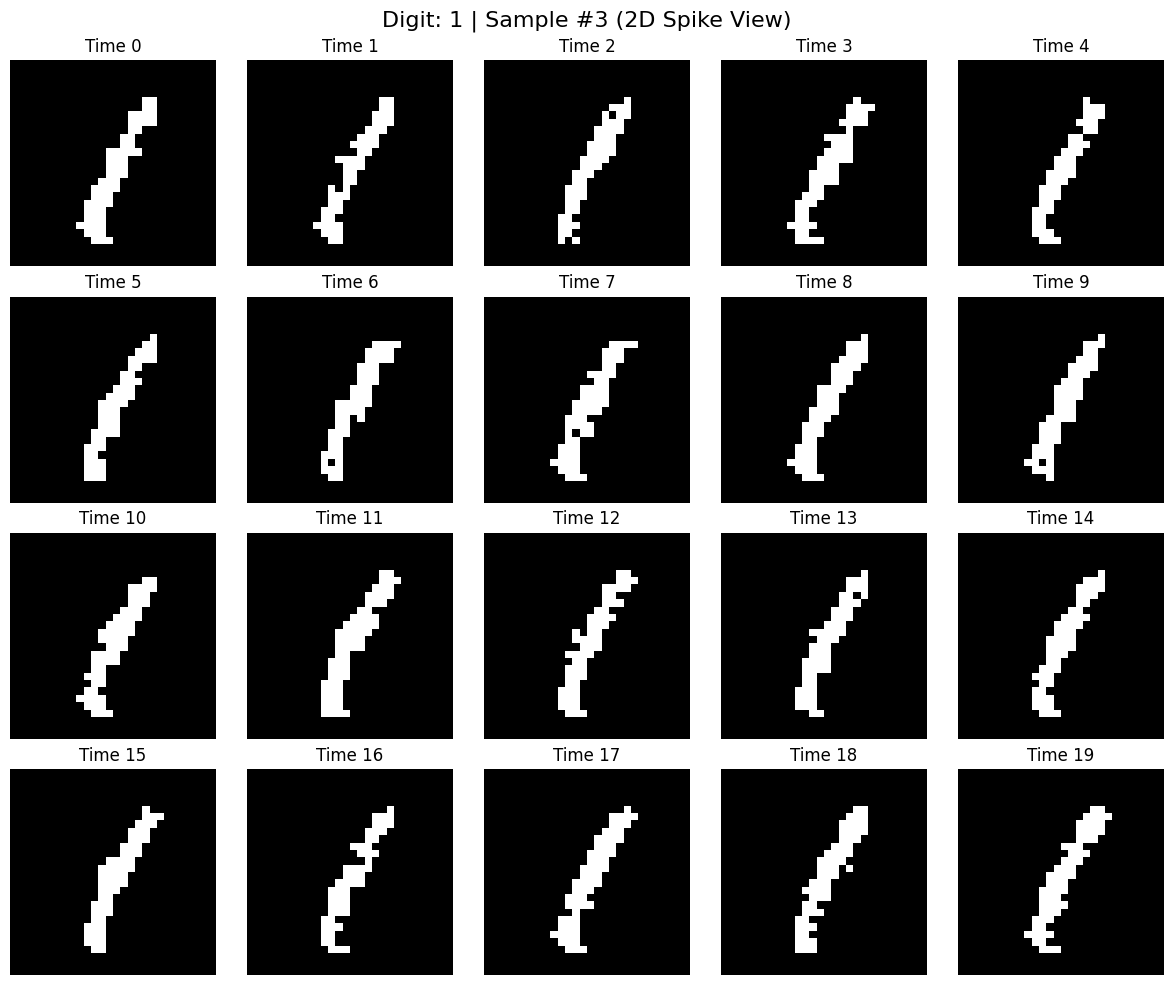

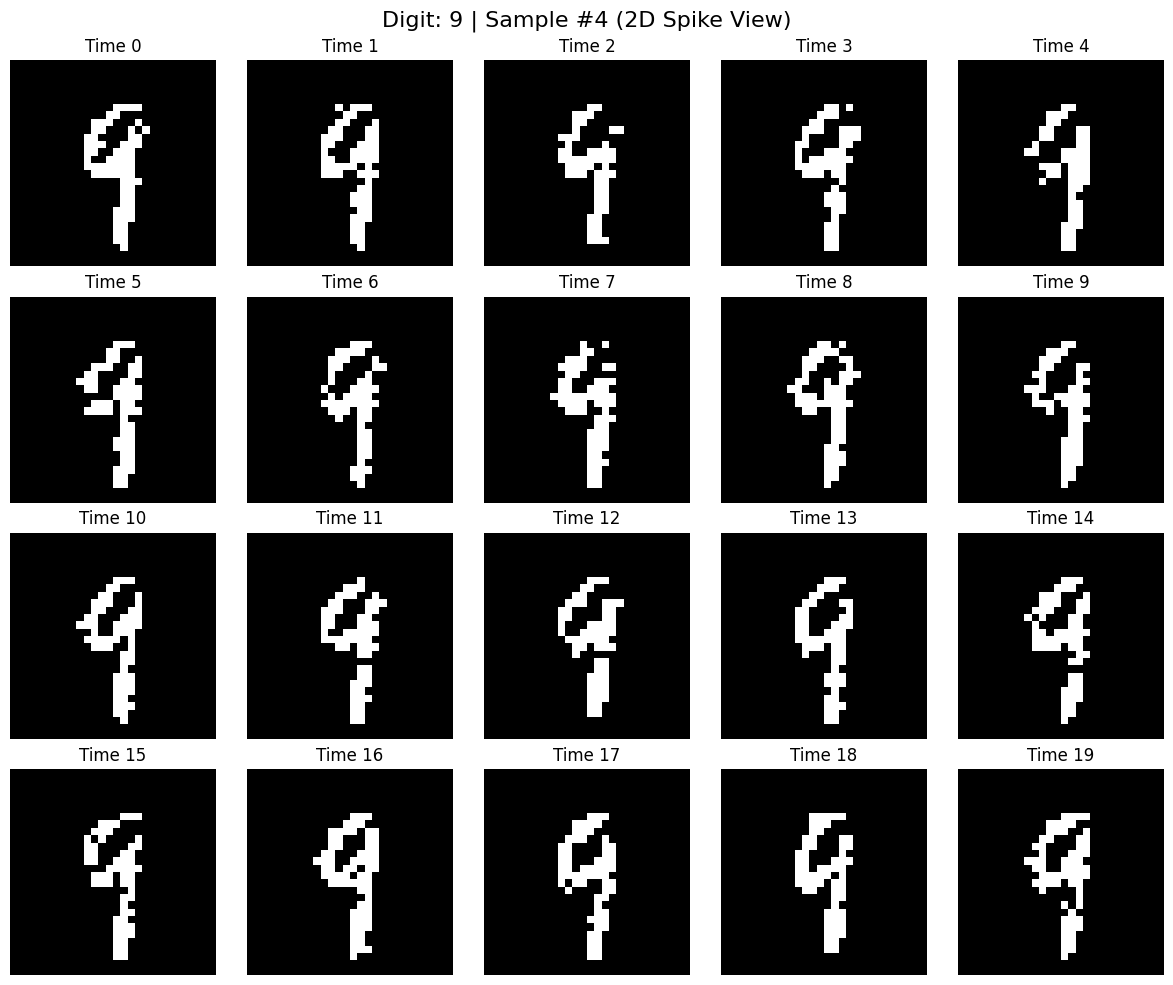

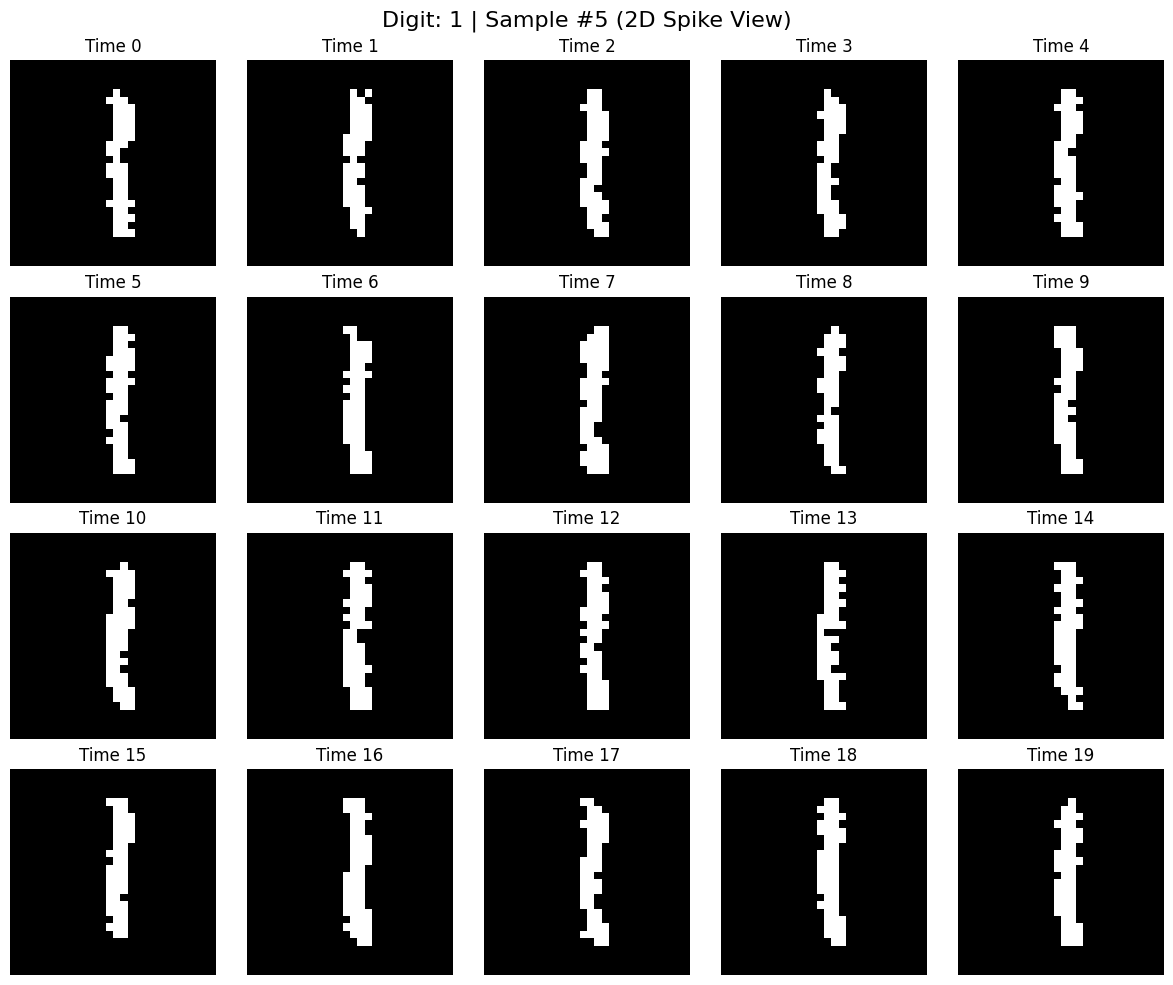

In [8]:
for i in range(num_samples):
    image = images[i]
    label = labels[i]
    spike_train = poisson_encode(image, T)
    visualize_spike_train_2d(spike_train, label, i + 1)

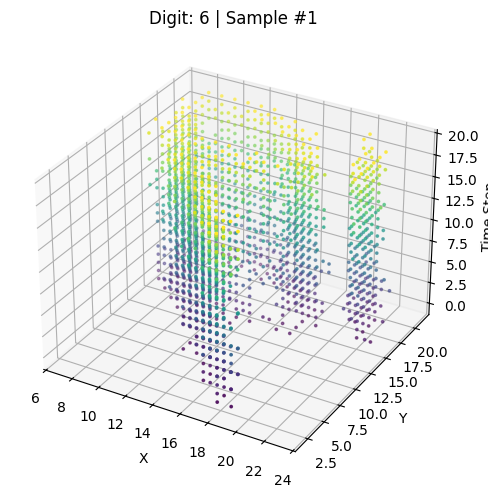

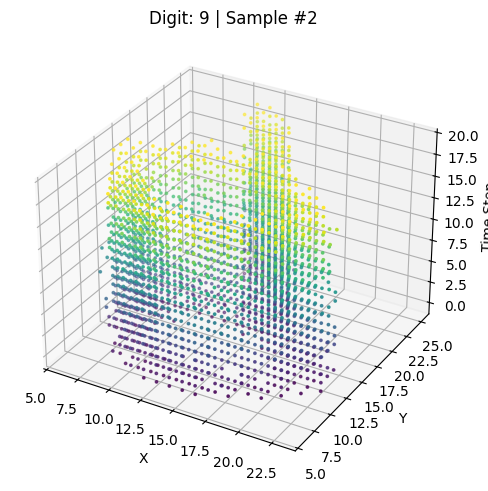

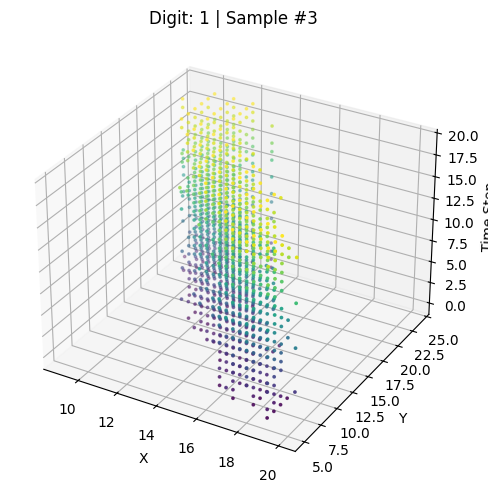

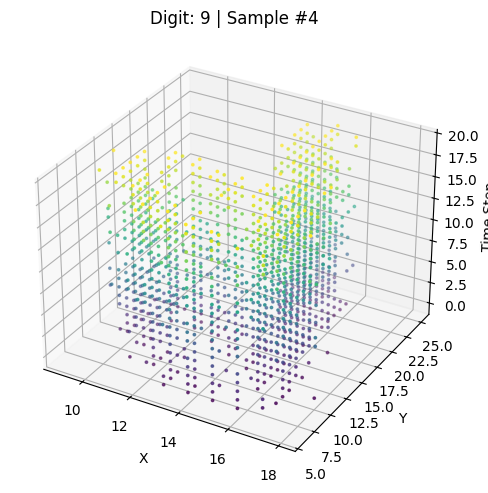

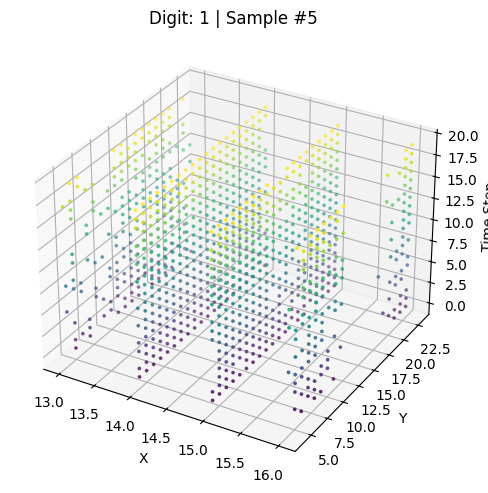

In [9]:
for i in range(num_samples):
    image = images[i]
    label = labels[i]
    spike_train = poisson_encode(image, T)
    visualize_spike_train(spike_train, label, i + 1)

STEP 2: SNN MODEL IMPLEMENTATION

In [3]:
np.random.seed(0)

T = 20
input_size = 784
hidden_size = 100
output_size = 10
threshold = 1.0
beta = 0.9

In [4]:
def poisson_encode(images, T):
    encoded = np.random.rand(T, *images.shape) < images[np.newaxis, ...]
    return encoded.astype(float)

In [5]:
def run_snn(spike_train, W1, W2):
    V_hidden = np.zeros(hidden_size)
    V_output = np.zeros(output_size)
    output_spike_counts = np.zeros(output_size)

    for t in range(T):
        x_t = spike_train[t].reshape(-1)
        I_h = np.dot(W1, x_t)
        V_hidden[:] = beta * V_hidden + I_h
        spikes_h = (V_hidden >= threshold).astype(float)
        V_hidden[spikes_h == 1] = 0

        I_o = np.dot(W2, spikes_h)
        V_output[:] = beta * V_output + I_o
        spikes_o = (V_output >= threshold).astype(float)
        V_output[spikes_o == 1] = 0

        output_spike_counts += spikes_o

    return output_spike_counts

In [6]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data[:1] / 255.0
y = mnist.target[:1].astype(int)
image = X[0].reshape(28, 28)

spike_train = poisson_encode(image, T)
W1 = np.random.normal(0, 0.1, (hidden_size, input_size))
W2 = np.random.normal(0, 0.1, (output_size, hidden_size))

output_spikes = run_snn(spike_train, W1, W2)

print("Output spike counts:", output_spikes)
print("Predicted label:", np.argmax(output_spikes))
print("True label:", y[0])

Output spike counts: [4. 2. 0. 7. 0. 2. 0. 0. 2. 1.]
Predicted label: 3
True label: 5


STEP 3: TRAINING AND EVALUATION

In [27]:
T = 50
input_size = 784
hidden_size = 250
output_size = 10
threshold = 0.5
beta = 0.98
lr = 2e-3
num_epochs = 10
num_train = 10000
num_test = 10000

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data[:num_train+num_test] / 255.0
y = mnist.target[:num_train+num_test].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test, random_state=42)

In [15]:
def poisson_encode(images, T):
    encoded = np.random.rand(T, *images.shape) < images[np.newaxis, ...]
    return encoded.astype(float)

In [16]:
def surrogate_derivative(v, threshold=1.0):
    alpha = 5.0
    x = np.clip(v - threshold, -10, 10)
    return alpha * np.exp(-alpha * x) / ((1 + np.exp(-alpha * x))**2)

In [17]:
W1 = np.random.normal(0, 0.05, (hidden_size, input_size))
W2 = np.random.normal(0, 0.05, (output_size, hidden_size))

In [26]:
train_acc_history = []

for epoch in range(num_epochs):
    correct = 0
    for i in range(num_train):
        image = X_train[i].reshape(28, 28) ** 2
        label = y_train[i]
        spike_train = poisson_encode(image, T).reshape(T, -1)

        V_hidden = np.zeros(hidden_size)
        V_output = np.zeros(output_size)
        spikes_hidden = np.zeros((T, hidden_size))
        spikes_output = np.zeros((T, output_size))
        V_mem_hidden = np.zeros((T, hidden_size))
        V_mem_output = np.zeros((T, output_size))

        dW1 = np.zeros_like(W1)
        dW2 = np.zeros_like(W2)

        for t in range(T):
            x_t = spike_train[t]
            I_h = W1 @ x_t
            V_hidden = beta * V_hidden + I_h
            s_h = (V_hidden >= threshold).astype(float)
            V_hidden[s_h == 1] = 0
            spikes_hidden[t] = s_h
            V_mem_hidden[t] = V_hidden

            I_o = W2 @ s_h
            V_output = beta * V_output + I_o
            s_o = (V_output >= threshold).astype(float)
            V_output[s_o == 1] = 0
            spikes_output[t] = s_o
            V_mem_output[t] = V_output

            target = np.zeros(output_size)
            target[label] = 1.0
            error_t = s_o - target

            grad_output = error_t * surrogate_derivative(V_mem_output[t], threshold=threshold)
            dW2 += np.outer(grad_output, s_h)

            grad_hidden = W2.T @ grad_output * surrogate_derivative(V_mem_hidden[t], threshold=threshold)
            dW1 += np.outer(grad_hidden, x_t)

        dW1 /= T
        dW2 /= T
        np.clip(dW1, -1, 1, out=dW1)
        np.clip(dW2, -1, 1, out=dW2)

        W1 -= lr * dW1
        W2 -= lr * dW2

        spike_counts = np.sum(spikes_output, axis=0)
        pred = np.argmax(spike_counts)
        if pred == label:
            correct += 1

    acc = correct / num_train * 100
    train_acc_history.append(acc)
    print(f"Epoch {epoch+1}: Train Accuracy = {acc:.2f}%")

Epoch 1: Train Accuracy = 89.91%
Epoch 2: Train Accuracy = 90.30%
Epoch 3: Train Accuracy = 90.82%
Epoch 4: Train Accuracy = 91.30%
Epoch 5: Train Accuracy = 91.79%
Epoch 6: Train Accuracy = 92.02%
Epoch 7: Train Accuracy = 92.12%
Epoch 8: Train Accuracy = 92.46%
Epoch 9: Train Accuracy = 92.41%
Epoch 10: Train Accuracy = 92.63%


In [28]:
correct_test = 0

for i in range(num_test):
    image = X_test[i].reshape(28, 28) ** 2
    label = y_test[i]
    spike_train = poisson_encode(image, T).reshape(T, -1)

    V_hidden = np.zeros(hidden_size)
    V_output = np.zeros(output_size)
    spikes_output = np.zeros((T, output_size))

    for t in range(T):
        x_t = spike_train[t]
        I_h = W1 @ x_t
        V_hidden = beta * V_hidden + I_h
        s_h = (V_hidden >= threshold).astype(float)
        V_hidden[s_h == 1] = 0

        I_o = W2 @ s_h
        V_output = beta * V_output + I_o
        s_o = (V_output >= threshold).astype(float)
        V_output[s_o == 1] = 0
        spikes_output[t] = s_o

    spike_counts = np.sum(spikes_output, axis=0)
    pred = np.argmax(spike_counts)
    if pred == label:
        correct_test += 1

test_acc = correct_test / num_test * 100
print(f"\n Final Test Accuracy = {test_acc:.2f}%")



 Final Test Accuracy = 92.35%


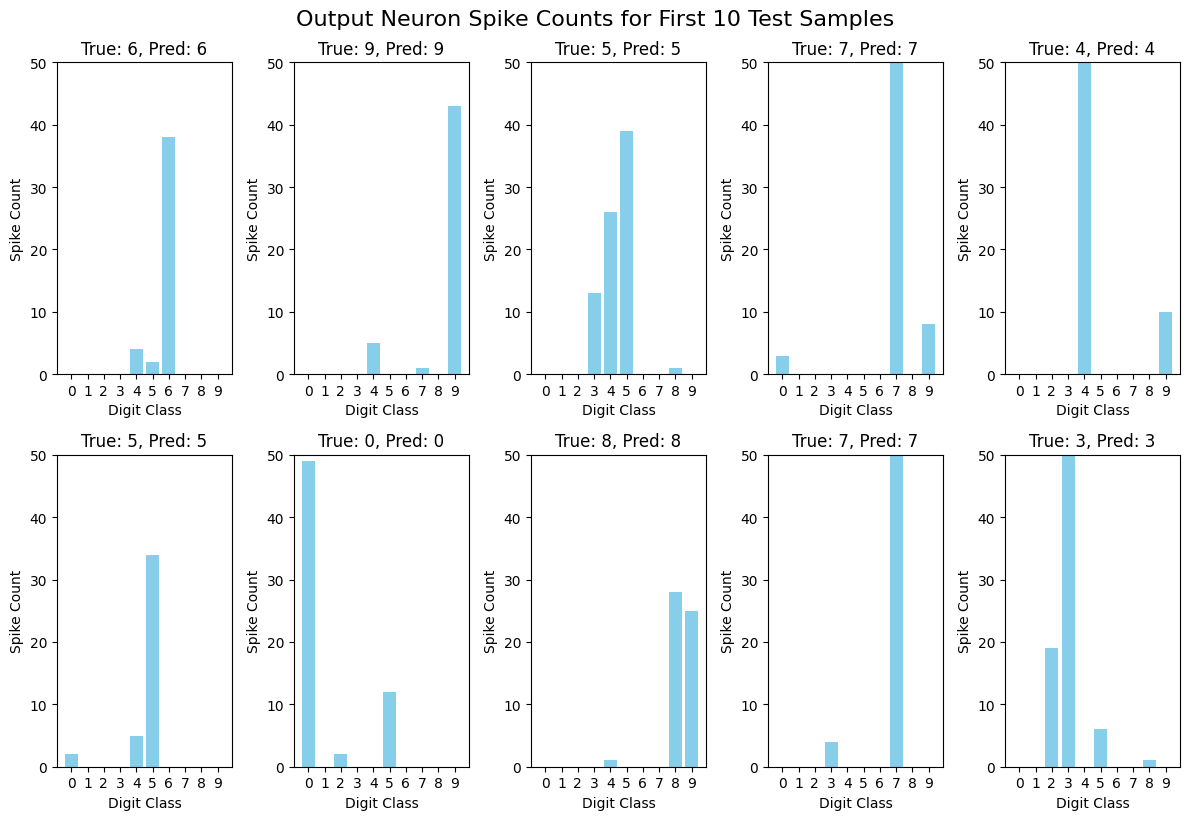

In [29]:
plt.figure(figsize=(12, 8))
for i in range(10):
    image = X_test[i].reshape(28, 28) ** 2
    label = y_test[i]
    spike_train = poisson_encode(image, T).reshape(T, -1)

    V_hidden = np.zeros(hidden_size)
    V_output = np.zeros(output_size)
    spikes_output = np.zeros((T, output_size))

    for t in range(T):
        x_t = spike_train[t]
        I_h = W1 @ x_t
        V_hidden = beta * V_hidden + I_h
        s_h = (V_hidden >= threshold).astype(float)
        V_hidden[s_h == 1] = 0

        I_o = W2 @ s_h
        V_output = beta * V_output + I_o
        s_o = (V_output >= threshold).astype(float)
        V_output[s_o == 1] = 0
        spikes_output[t] = s_o

    spike_counts = np.sum(spikes_output, axis=0)
    pred = np.argmax(spike_counts)

    plt.subplot(2, 5, i + 1)
    plt.bar(range(10), spike_counts, color='skyblue')
    plt.xticks(range(10))
    plt.title(f"True: {label}, Pred: {pred}")
    plt.xlabel("Digit Class")
    plt.ylabel("Spike Count")
    plt.ylim(0, T)

plt.tight_layout()
plt.suptitle("Output Neuron Spike Counts for First 10 Test Samples", fontsize=16, y=1.02)
plt.show()
